## ASTR 597A Homework 5
Eric Bellm

Due Feb 7, 2023

Your name: Tom Wagg
    
Your collaborators:

In this homework we will attempt to "replicate" a classic SDSS paper ([Baldry et al. 2004](https://ui.adsabs.harvard.edu/abs/2004ApJ...600..681B/abstract)) with simulated Rubin data. Plotting the absolute r-band magnitudes of low-redshift galaxies vs. their (u-r) colors shows clearly the red sequence, blue clump, and green valley populations.  We will investigate if the DP0.2 galaxies show the same distribution, explore the implications since we won't have (many) spectroscopic redshifts, and look at possible evolution with redshift...

Portions of this work were developed based on [this notebook](https://github.com/rubin-dp0/delegate-contributions-dp02/tree/main/photoz/CMNN_Estimator) by Melissa Graham.

We will need to deal with "k-corrections" in order to convert our observer frame photometry to the rest frame.  See [Hogg et al. 2002](https://ui.adsabs.harvard.edu/abs/2002astro.ph.10394H/abstract) for a pedagogical overview.

The python package `kcorrect` by Mike Blanton provides our easist way to deal with this.  The package documentation is [here](https://kcorrect.readthedocs.io/), the source code [here](https://github.com/blanton144/kcorrect), and the paper describing the algorithm is [here](https://ui.adsabs.harvard.edu/abs/2007AJ....133..734B/abstract).

In [ ]:
# As of Jan. 29, 2023, pypi version throws an error: install from github directly
!pip install --user git+https://github.com/blanton144/kcorrect.git

## Exercise 1: Low-redshift galaxy CMD with LSST

Plot the absolute r magnitude vs. rest-frame u-r color for 50,000 galaxies with z < 0.08.

In [216]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy.ma as ma

from scipy.stats import chi2
import datetime

%config InlineBackend.figure_format = "retina"

In [2]:
from lsst.rsp import get_tap_service, retrieve_query
service = get_tap_service()

Since we're going to need more columns than you might expect in this homework and the query is slow (~20 minutes), I'm going to provide the SQL query:

In [3]:
query = "SELECT mt.id_truth_type AS mt_id_truth_type, "\
        "mt.match_objectId AS mt_match_objectId, "\
        "ts.truth_type AS ts_truth_type, "\
        "ts.redshift AS ts_redshift, "\
        "scisql_nanojanskyToAbMag(ts.flux_u) AS ts_mag_u, "\
        "scisql_nanojanskyToAbMag(ts.flux_g) AS ts_mag_g, "\
        "scisql_nanojanskyToAbMag(ts.flux_r) AS ts_mag_r, "\
        "scisql_nanojanskyToAbMag(ts.flux_i) AS ts_mag_i, "\
        "scisql_nanojanskyToAbMag(ts.flux_z) AS ts_mag_z, "\
        "scisql_nanojanskyToAbMag(ts.flux_y) AS ts_mag_y, "\
        "scisql_nanojanskyToAbMag(obj.u_cModelFlux) AS obj_cModelMag_u, "\
        "scisql_nanojanskyToAbMag(obj.g_cModelFlux) AS obj_cModelMag_g, "\
        "scisql_nanojanskyToAbMag(obj.r_cModelFlux) AS obj_cModelMag_r, "\
        "scisql_nanojanskyToAbMag(obj.i_cModelFlux) AS obj_cModelMag_i, "\
        "scisql_nanojanskyToAbMag(obj.z_cModelFlux) AS obj_cModelMag_z, "\
        "scisql_nanojanskyToAbMag(obj.y_cModelFlux) AS obj_cModelMag_y, "\
        "scisql_nanojanskyToAbMagSigma(obj.u_cModelFlux,obj.u_cModelFluxErr) AS obj_cModelMagErr_u, "\
        "scisql_nanojanskyToAbMagSigma(obj.g_cModelFlux,obj.g_cModelFluxErr) AS obj_cModelMagErr_g, "\
        "scisql_nanojanskyToAbMagSigma(obj.r_cModelFlux,obj.r_cModelFluxErr) AS obj_cModelMagErr_r, "\
        "scisql_nanojanskyToAbMagSigma(obj.i_cModelFlux,obj.i_cModelFluxErr) AS obj_cModelMagErr_i, "\
        "scisql_nanojanskyToAbMagSigma(obj.z_cModelFlux,obj.z_cModelFluxErr) AS obj_cModelMagErr_z, "\
        "scisql_nanojanskyToAbMagSigma(obj.y_cModelFlux,obj.y_cModelFluxErr) AS obj_cModelMagErr_y "\
        "FROM dp02_dc2_catalogs.MatchesTruth AS mt "\
        "JOIN dp02_dc2_catalogs.TruthSummary AS ts ON mt.id_truth_type = ts.id_truth_type "\
        "JOIN dp02_dc2_catalogs.Object AS obj ON mt.match_objectId = obj.objectId "\
        "WHERE ts.truth_type = 1 "\
        "AND ts.redshift < 0.08 "\
        "LIMIT 50000"
print(query)

SELECT mt.id_truth_type AS mt_id_truth_type, mt.match_objectId AS mt_match_objectId, ts.truth_type AS ts_truth_type, ts.redshift AS ts_redshift, scisql_nanojanskyToAbMag(ts.flux_u) AS ts_mag_u, scisql_nanojanskyToAbMag(ts.flux_g) AS ts_mag_g, scisql_nanojanskyToAbMag(ts.flux_r) AS ts_mag_r, scisql_nanojanskyToAbMag(ts.flux_i) AS ts_mag_i, scisql_nanojanskyToAbMag(ts.flux_z) AS ts_mag_z, scisql_nanojanskyToAbMag(ts.flux_y) AS ts_mag_y, scisql_nanojanskyToAbMag(obj.u_cModelFlux) AS obj_cModelMag_u, scisql_nanojanskyToAbMag(obj.g_cModelFlux) AS obj_cModelMag_g, scisql_nanojanskyToAbMag(obj.r_cModelFlux) AS obj_cModelMag_r, scisql_nanojanskyToAbMag(obj.i_cModelFlux) AS obj_cModelMag_i, scisql_nanojanskyToAbMag(obj.z_cModelFlux) AS obj_cModelMag_z, scisql_nanojanskyToAbMag(obj.y_cModelFlux) AS obj_cModelMag_y, scisql_nanojanskyToAbMagSigma(obj.u_cModelFlux,obj.u_cModelFluxErr) AS obj_cModelMagErr_u, scisql_nanojanskyToAbMagSigma(obj.g_cModelFlux,obj.g_cModelFluxErr) AS obj_cModelMagErr_g, s

In [6]:
# %%time
# job = service.submit_job(query)
# print('Job URL is', job.url)
# print('Job phase is', job.phase)
# job.run()
# job.wait(phases=['COMPLETED', 'ERROR'])
# print('Job phase is', job.phase)

Job URL is https://data.lsst.cloud/api/tap/async/s5thxgabcgjwefmf
Job phase is PENDING
Job phase is COMPLETED
CPU times: user 117 ms, sys: 15.5 ms, total: 133 ms
Wall time: 13min 53s


In [7]:
# df = job.fetch_result().to_table().to_pandas()

In [8]:
# since the query is slow let's save the safe_df
# df.to_parquet('lowz_query_safe_df.parquet')

In [4]:
# reread from file if needed
df = pd.read_parquet('lowz_query_safe_df.parquet')

We now have the true redshifts and both true and "observed" magnitudes in all bands for sources we know are galaxies (`ts.truth_type == 1`; this is a bit of a cheat!).  To get the absolute magnitude we need the distance modulus and the k-correction (see the references above, or [here](https://kcorrect.readthedocs.io/en/5.0.0b/basics.html#) for a briefer overview).  (The rest-frame color requires the k-corrections as well.)  To use `kcorrect` we need to make some unit conversions.

`kcorrect` doesn't have LSST bands in it.  So we will approximate with SDSS ugriz.

In [5]:
import kcorrect.kcorrect

responses = ['sdss_u0', 'sdss_g0', 'sdss_r0', 'sdss_i0', 'sdss_z0']
kc = kcorrect.kcorrect.Kcorrect(responses=responses)

`kcorrect` wants inputs in units of maggies and their inverse variances, as numpy arrays with dimensions (objects x filters).  For convenience here is that conversion:

In [14]:
safe_df = df.dropna(subset=['obj_cModelMag_u', 'obj_cModelMag_g', 'obj_cModelMag_r',
       'obj_cModelMag_i', 'obj_cModelMag_z', 'obj_cModelMagErr_u', 'obj_cModelMagErr_g', 'obj_cModelMagErr_r',
       'obj_cModelMagErr_i', 'obj_cModelMagErr_z', 'ts_redshift'])

In [71]:
maggies = safe_df[['obj_cModelMag_u', 'obj_cModelMag_g', 'obj_cModelMag_r',
                   'obj_cModelMag_i', 'obj_cModelMag_z']].apply(lambda x: 10.0 ** (-0.4 * x)).values

In [70]:
ivar = safe_df[['obj_cModelMagErr_u', 'obj_cModelMagErr_g', 'obj_cModelMagErr_r',
                'obj_cModelMagErr_i', 'obj_cModelMagErr_z']].apply(
    lambda x: 1./ (0.4 * np.log(10) * x) ** 2.).values / (maggies**2.)

In [24]:
redshift = safe_df["ts_redshift"]

In [72]:
coeffs = kc.fit_coeffs(redshift=redshift, maggies=maggies, ivar=ivar)


 NNLS quitting on iteration count.

 NNLS quitting on iteration count.


In [29]:
absmag = kc.absmag(redshift=redshift, maggies=maggies, ivar=ivar, coeffs=coeffs)

In [73]:
u_mag, r_mag = absmag[:, 0], absmag[:, 2]

Now use `kcorrect` to compute the rest-frame absolute magnitude in r-band as well as the rest frame u-r color, and plot them.  Note that you'll need to exclude some rows with `NaN`s.

Compare your result qualitatively to Figure 1 of Baldry et al. 2004.

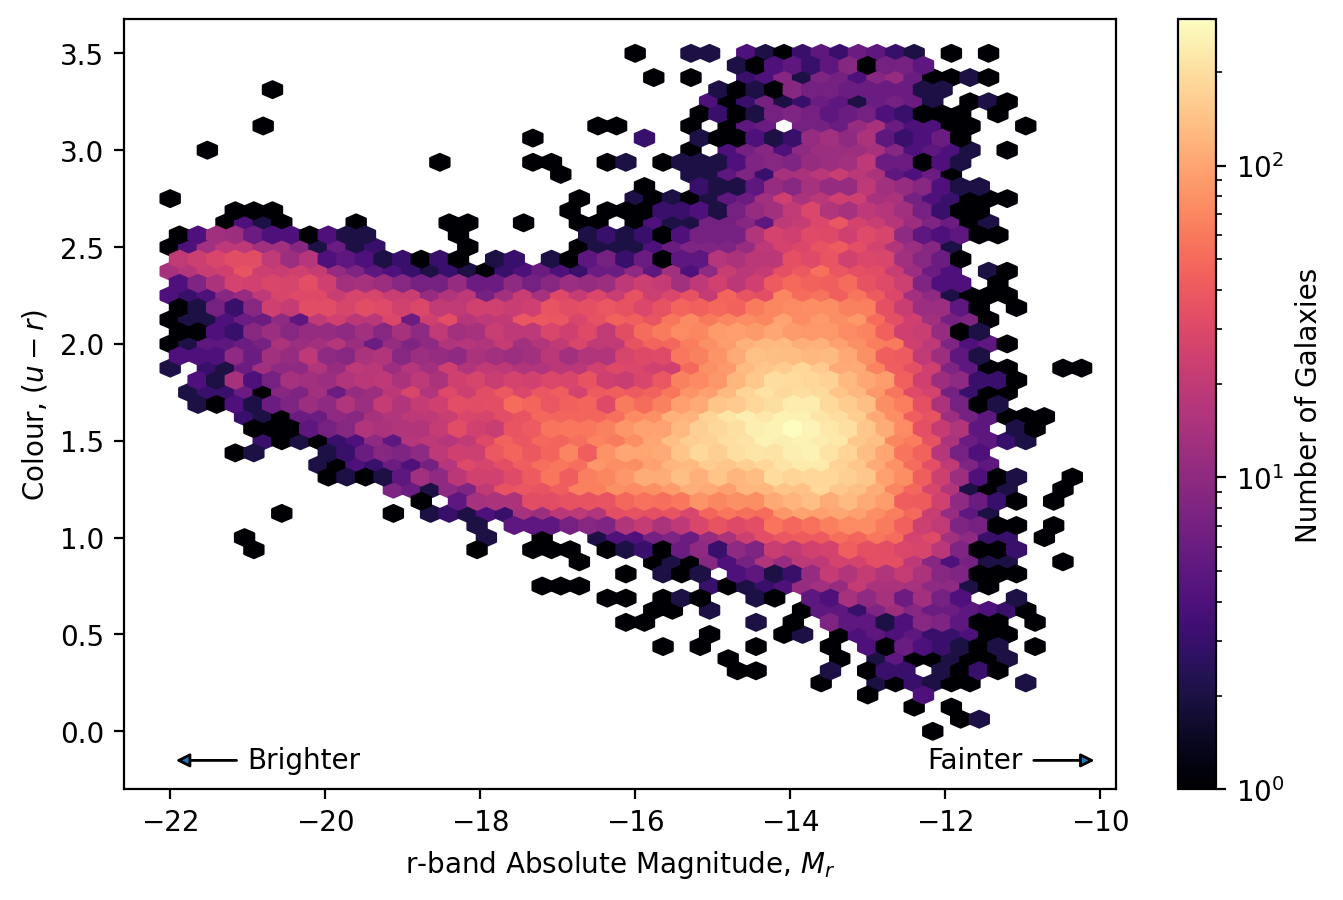

In [92]:
fig, ax = plt.subplots(figsize=(8, 5))

hexbin = ax.hexbin(r_mag, u_mag - r_mag, extent=(-22, -10, 0, 3.5), gridsize=50, bins="log", cmap="magma")
fig.colorbar(hexbin, label="Number of Galaxies")

ax.annotate("Brighter", xy=(-22, -0.15), xytext=(-21, -0.15), arrowprops=dict(arrowstyle="-|>"), va="center")
ax.annotate("Fainter", xy=(-10, -0.15), xytext=(-11, -0.15), arrowprops=dict(arrowstyle="-|>"), va="center", ha="right")

ax.set_xlim(right=-9.8)
ax.set_ylim(bottom=-0.3)

ax.set_xlabel("r-band Absolute Magnitude, $M_r$")
ax.set_ylabel("Colour, $(u - r)$")
plt.show()

For ease of comparison, here's the plot from Baldry+2004

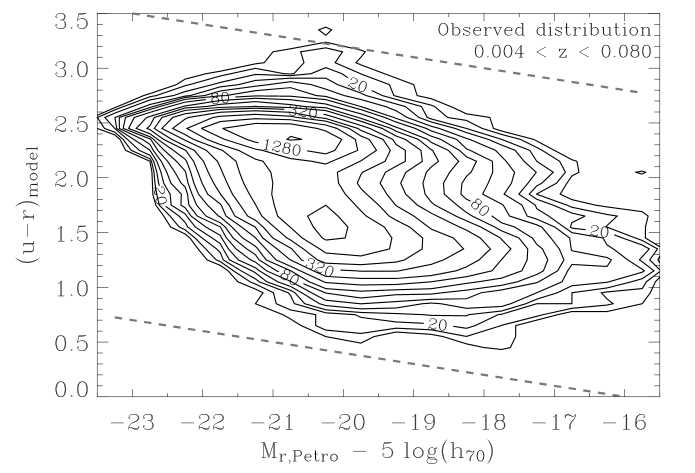

We can see that the peak of the distribution from the new plot is shifted to much fainter magnitudes, the peak has moved about 7 magnitudes fainter! I think this is due to LSST's increased depth and therefore ability to pick of galaxies at these fainter magnitudes.

## Exercise 2: Removing a cheat

We made two cheats above: we used the truth table to tell us which galaxies we have as well as their redshifts.  In SDSS those redshifts were obtained through spectroscopy, but for Rubin most redshifts will have to be obtained photometrically.

Using the data from our query above, follow [this notebook](https://github.com/rubin-dp0/delegate-contributions-dp02/tree/main/photoz/CMNN_Estimator) by Melissa Graham to compute a very simple photo-z for these galaxies.  Plot the true redshift vs estimated photo-z, and then re-plot the CMD from Exercise 1 using photo-z rather than the true spectroscopic redshift.

In [97]:
data_id = np.asarray(safe_df['mt_match_objectId'], dtype='int')



# true ("spec") redshifts
data_tz = np.asarray(safe_df['ts_redshift'], dtype='float')

# true ("spec") magnitudes
data_tm = np.transpose(np.asarray((safe_df['ts_mag_u'],safe_df['ts_mag_g'],\
                                   safe_df['ts_mag_r'],safe_df['ts_mag_i'],\
                                   safe_df['ts_mag_z'],safe_df['ts_mag_y']),\
                                  dtype='float' ) )

# object apparent magnitudes
data_om = np.transpose(np.asarray((safe_df['obj_cModelMag_u'],safe_df['obj_cModelMag_g'],\
                                   safe_df['obj_cModelMag_r'],safe_df['obj_cModelMag_i'],\
                                   safe_df['obj_cModelMag_z'],safe_df['obj_cModelMag_y']),\
                                  dtype='float' ) )

# object apparent magnitude errors
data_ome = np.transpose(np.asarray((safe_df['obj_cModelMagErr_u'],safe_df['obj_cModelMagErr_g'],\
                                    safe_df['obj_cModelMagErr_r'],safe_df['obj_cModelMagErr_i'],\
                                    safe_df['obj_cModelMagErr_z'],safe_df['obj_cModelMagErr_y']),\
                                   dtype='float' ) )



# true ("spec") and object colors and color errors
data_tc = np.zeros( (len(data_om),5), dtype='float' )
data_oc = np.zeros( (len(data_om),5), dtype='float' )
data_oce = np.zeros( (len(data_om),5), dtype='float' )

data_tc[:,0] = data_tm[:,0] - data_tm[:,1]
data_tc[:,1] = data_tm[:,1] - data_tm[:,2]
data_tc[:,2] = data_tm[:,2] - data_tm[:,3]
data_tc[:,3] = data_tm[:,3] - data_tm[:,4]
data_tc[:,4] = data_tm[:,4] - data_tm[:,5]

data_oc[:,0] = data_om[:,0] - data_om[:,1]
data_oc[:,1] = data_om[:,1] - data_om[:,2]
data_oc[:,2] = data_om[:,2] - data_om[:,3]
data_oc[:,3] = data_om[:,3] - data_om[:,4]
data_oc[:,4] = data_om[:,4] - data_om[:,5]

data_oce[:,0] = np.sqrt( data_ome[:,0]**2 + data_ome[:,1]**2 )
data_oce[:,1] = np.sqrt( data_ome[:,1]**2 + data_ome[:,2]**2 )
data_oce[:,2] = np.sqrt( data_ome[:,2]**2 + data_ome[:,3]**2 )
data_oce[:,3] = np.sqrt( data_ome[:,3]**2 + data_ome[:,4]**2 )
data_oce[:,4] = np.sqrt( data_ome[:,4]**2 + data_ome[:,5]**2 )

In [102]:
cmnn_ppf = 0.68 
cmnn_minNclr = 5

cmnn_thresh_table = np.zeros(6, dtype='float')
for d in range(6):
    cmnn_thresh_table[d] = chi2.ppf(cmnn_ppf,d)
cmnn_thresh_table[0] = float(0.0000)

for d in range(6):
    print('degrees of freedom = %1i, threshold = %5.3f' % (d, np.round(cmnn_thresh_table[d],3)))

degrees of freedom = 0, threshold = 0.000
degrees of freedom = 1, threshold = 0.989
degrees of freedom = 2, threshold = 2.279
degrees of freedom = 3, threshold = 3.506
degrees of freedom = 4, threshold = 4.695
degrees of freedom = 5, threshold = 5.861


In [103]:
data_pz = np.zeros(len(data_tz), dtype='float') - 1.0
data_pze = np.zeros(len(data_tz), dtype='float') - 1.0

In [122]:
Ncalc = len(data_tz)

In [210]:
%%time
t1 = datetime.datetime.now()

for i, r in enumerate(range(len(data_pz))):
    if (i + 1) % 1000 == 0:
        t2 = datetime.datetime.now()
        print(i, t2-t1, ((t2-t1)/float(i))*(float(Ncalc)) - (t2 - t1), ' remaining' )

    # calculate DM and DOF
    DM  = np.nansum((data_oc[r,:] - data_tc[:,:])**2 / data_oce[r,:]**2, axis=1, dtype='float')
    DOF = np.nansum((data_oc[r,:]**2 + data_tc[:,:]**2 + 1.0) / (data_oc[r,:]**2 + data_tc[:,:]**2 + 1.0), axis=1, dtype='int')
    
    # calculate the thresholds
    data_th = np.zeros(len(DOF), dtype='float')
    for d in range(6):
        tx = np.where(DOF == d)[0]
        data_th[tx] = cmnn_thresh_table[d]
        del tx
    
    DM[r] = 99.9

    # identify the CMNN subset of training-set galaxies:
    # those for which the DM is less than the threshold
    ix = np.where((DOF >= cmnn_minNclr) & (data_th > 0.00010) & \
                  (DM > 0.00010) & (DM <= data_th))[0]
    
    if len(ix) > 0:
        # choose a random training-set galaxy from the CMNN subset
        rix = np.random.choice(ix, size=1, replace=False)[0]
        data_pz[r] = data_tz[rix]
        data_pze[r] = np.std(data_tz[ix])
        del rix
    else:
        data_pz[r] = float('nan')
        data_pze[r] = float('nan')
        
    del DM, DOF, data_th, ix

999 0:00:05.634388 0:04:30.578972  remaining
1999 0:00:11.345248 0:04:26.582202  remaining
2999 0:00:16.984919 0:04:20.403817  remaining
3999 0:00:22.587880 0:04:14.017272  remaining
4999 0:00:28.242283 0:04:08.460817  remaining
5999 0:00:33.905449 0:04:02.895599  remaining
6999 0:00:39.582997 0:03:57.413947  remaining
7999 0:00:45.196393 0:03:51.506707  remaining
8999 0:00:50.846362 0:03:45.856738  remaining
9999 0:00:56.499305 0:03:40.203795  remaining
10999 0:01:02.113176 0:03:34.443002  remaining
11999 0:01:07.764010 0:03:28.792168  remaining
12999 0:01:13.563031 0:03:23.580835  remaining
13999 0:01:19.551065 0:03:18.768177  remaining
14999 0:01:25.599245 0:03:13.895373  remaining
15999 0:01:31.646183 0:03:08.876889  remaining
16999 0:01:37.722035 0:03:03.829491  remaining
17999 0:01:43.723364 0:02:58.513798  remaining
18999 0:01:49.777693 0:02:53.194079  remaining
19999 0:01:55.821548 0:02:47.786886  remaining
20999 0:02:01.817942 0:02:42.280232  remaining
21999 0:02:07.844651 0:0

In [211]:
tx = np.where( np.isnan(data_pz) )[0]
print( len(tx), ' galaxies did not get a pz estimate' )
del tx

tx = np.where( data_pz > 0.0 )[0]
print( len(tx), ' galaxies did get a pz estimate' )
del tx

24714  galaxies did not get a pz estimate
24260  galaxies did get a pz estimate


## True vs. Photo-Z

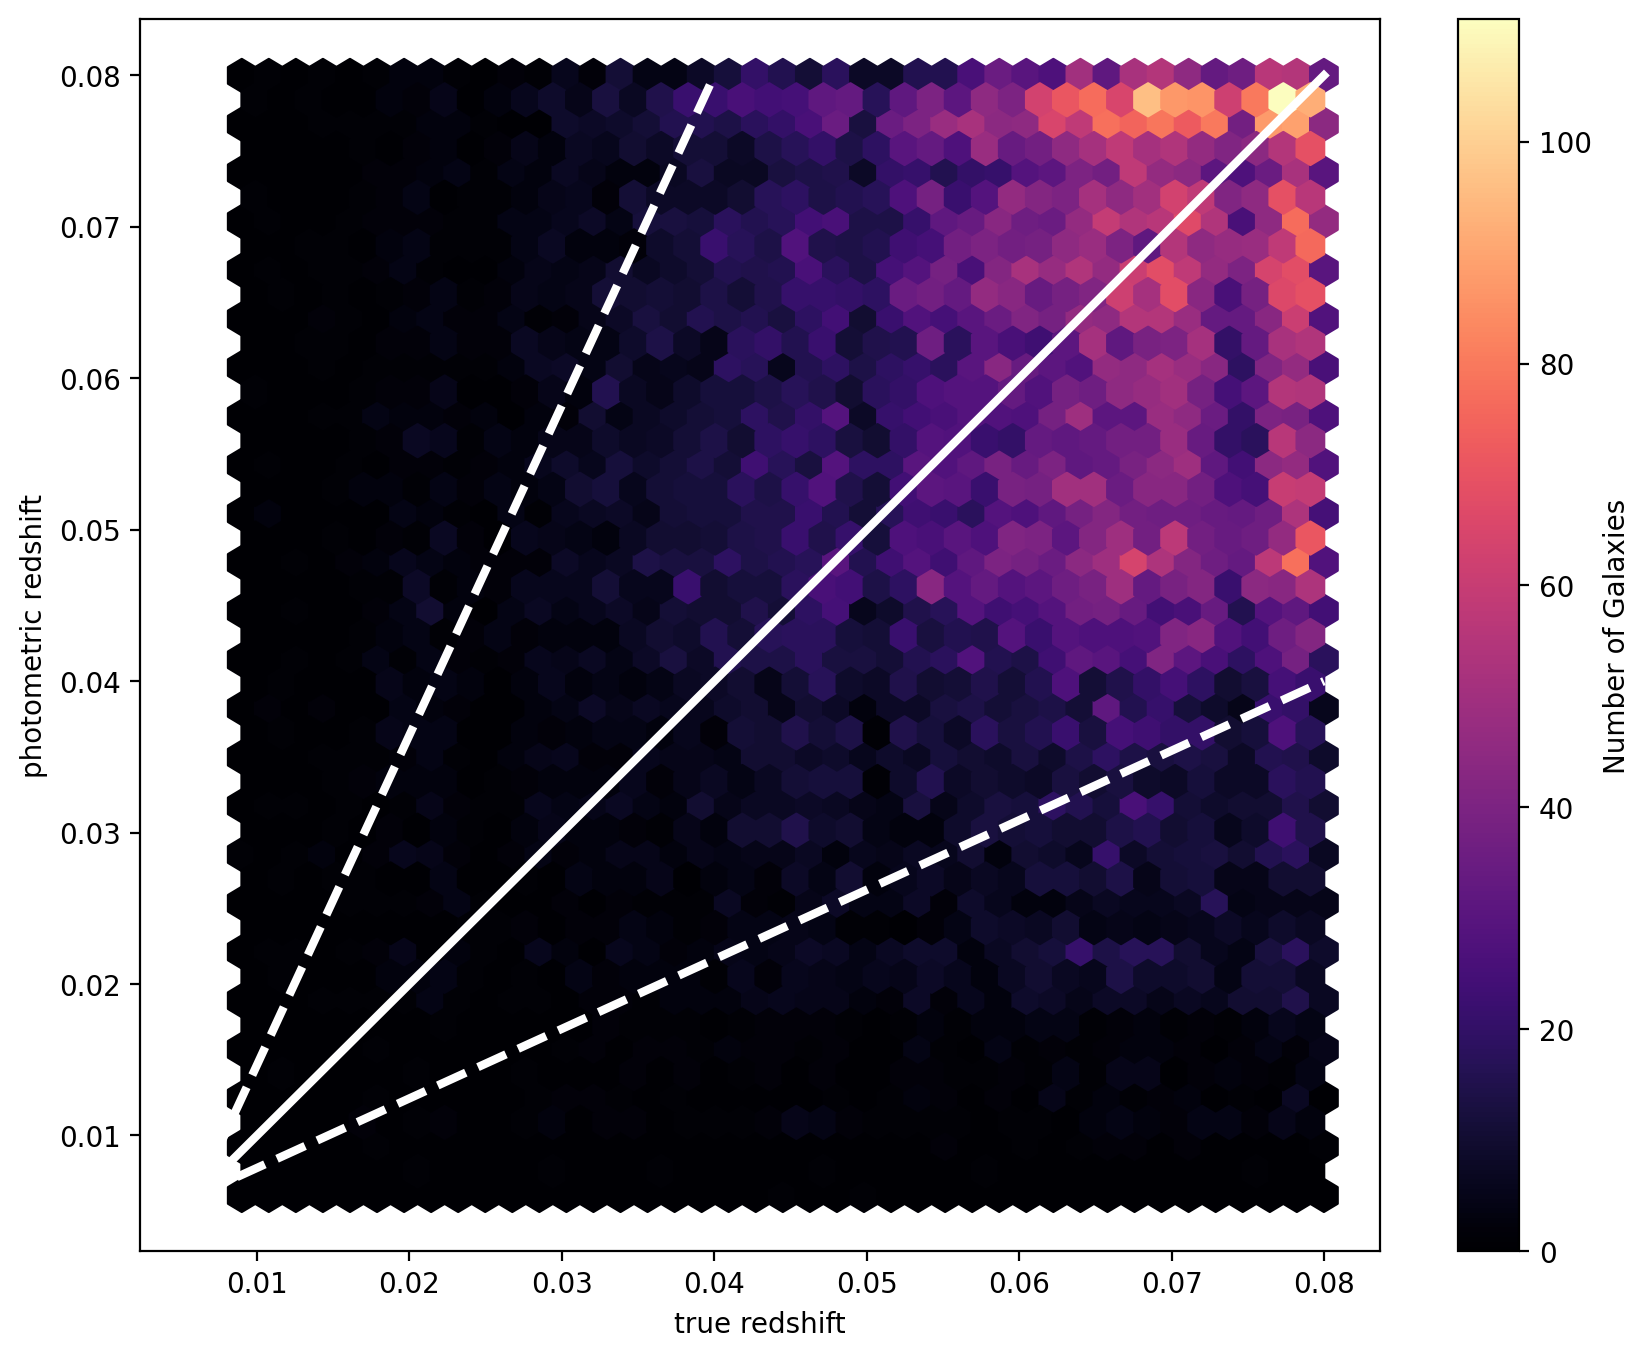

In [212]:
good_zs = ~np.isnan(data_pz)
ratio = data_tz / data_pz
min_z, max_z = np.min(data_pz[good_zs]), np.max(data_pz[good_zs])

fig = plt.figure(figsize=(10, 8))

hexbin = plt.hexbin(data_tz[good_zs], data_pz[good_zs], gridsize=40, cmap="magma")
plt.colorbar(hexbin, label="Number of Galaxies")

plt.plot([min_z, max_z], [min_z, max_z], lw=3, color='white', linestyle="-")
plt.plot([min_z, max_z / 2], [min_z, max_z], lw=3, color='white', linestyle="--")
plt.plot([min_z, max_z], [min_z, max_z / 2], lw=3, color='white', linestyle="--")

plt.xlabel('true redshift')
plt.ylabel('photometric redshift')
plt.show()

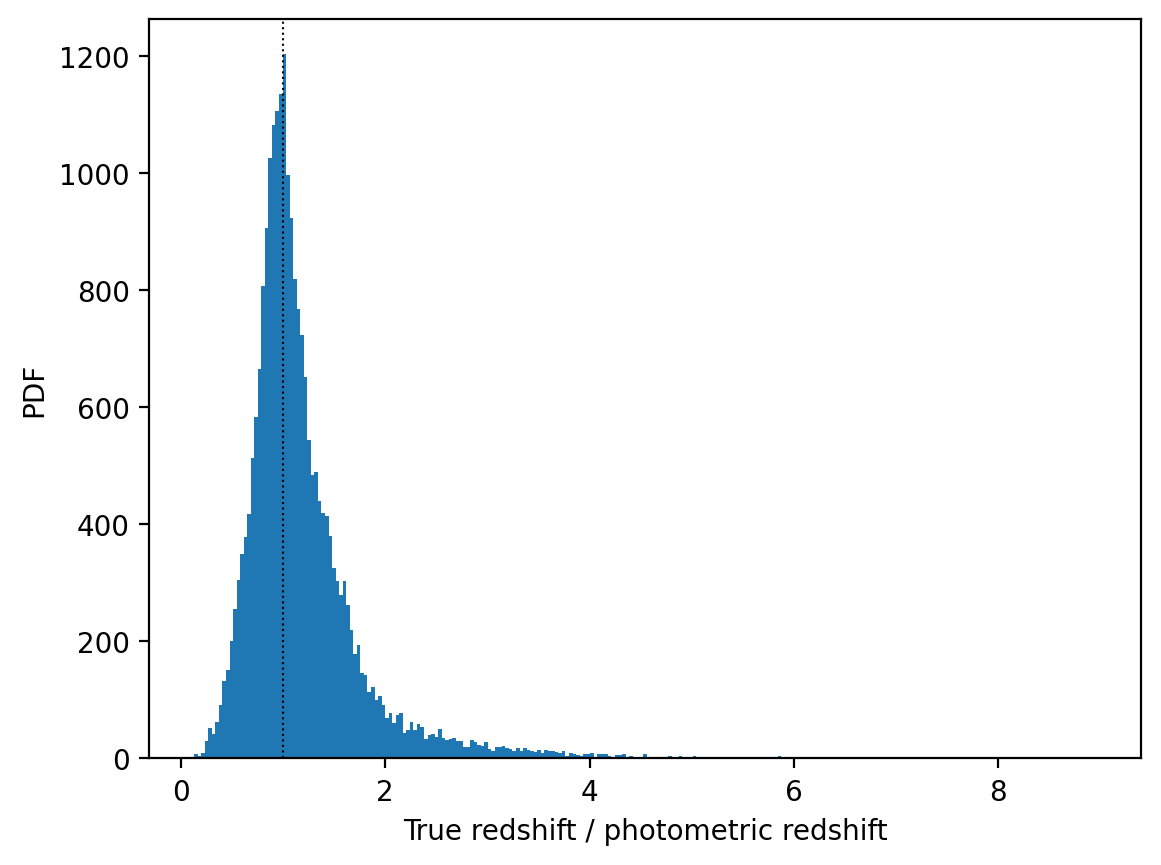

In [213]:
plt.hist(ratio[good_zs], bins="fd")
plt.axvline(1.0, color="black", linestyle="dotted", lw=0.75)
plt.xlabel("True redshift / photometric redshift")
plt.ylabel("PDF")
plt.show()

## Photo-Z CMD

In [214]:
photoz_coeffs = kc.fit_coeffs(redshift=data_pz[good_zs], maggies=maggies[good_zs], ivar=ivar[good_zs])
photoz_absmag = kc.absmag(redshift=data_pz[good_zs], maggies=maggies[good_zs], ivar=ivar[good_zs], coeffs=photoz_coeffs)
photoz_u_mag, photoz_r_mag = photoz_absmag[:, 0], photoz_absmag[:, 2]


 NNLS quitting on iteration count.


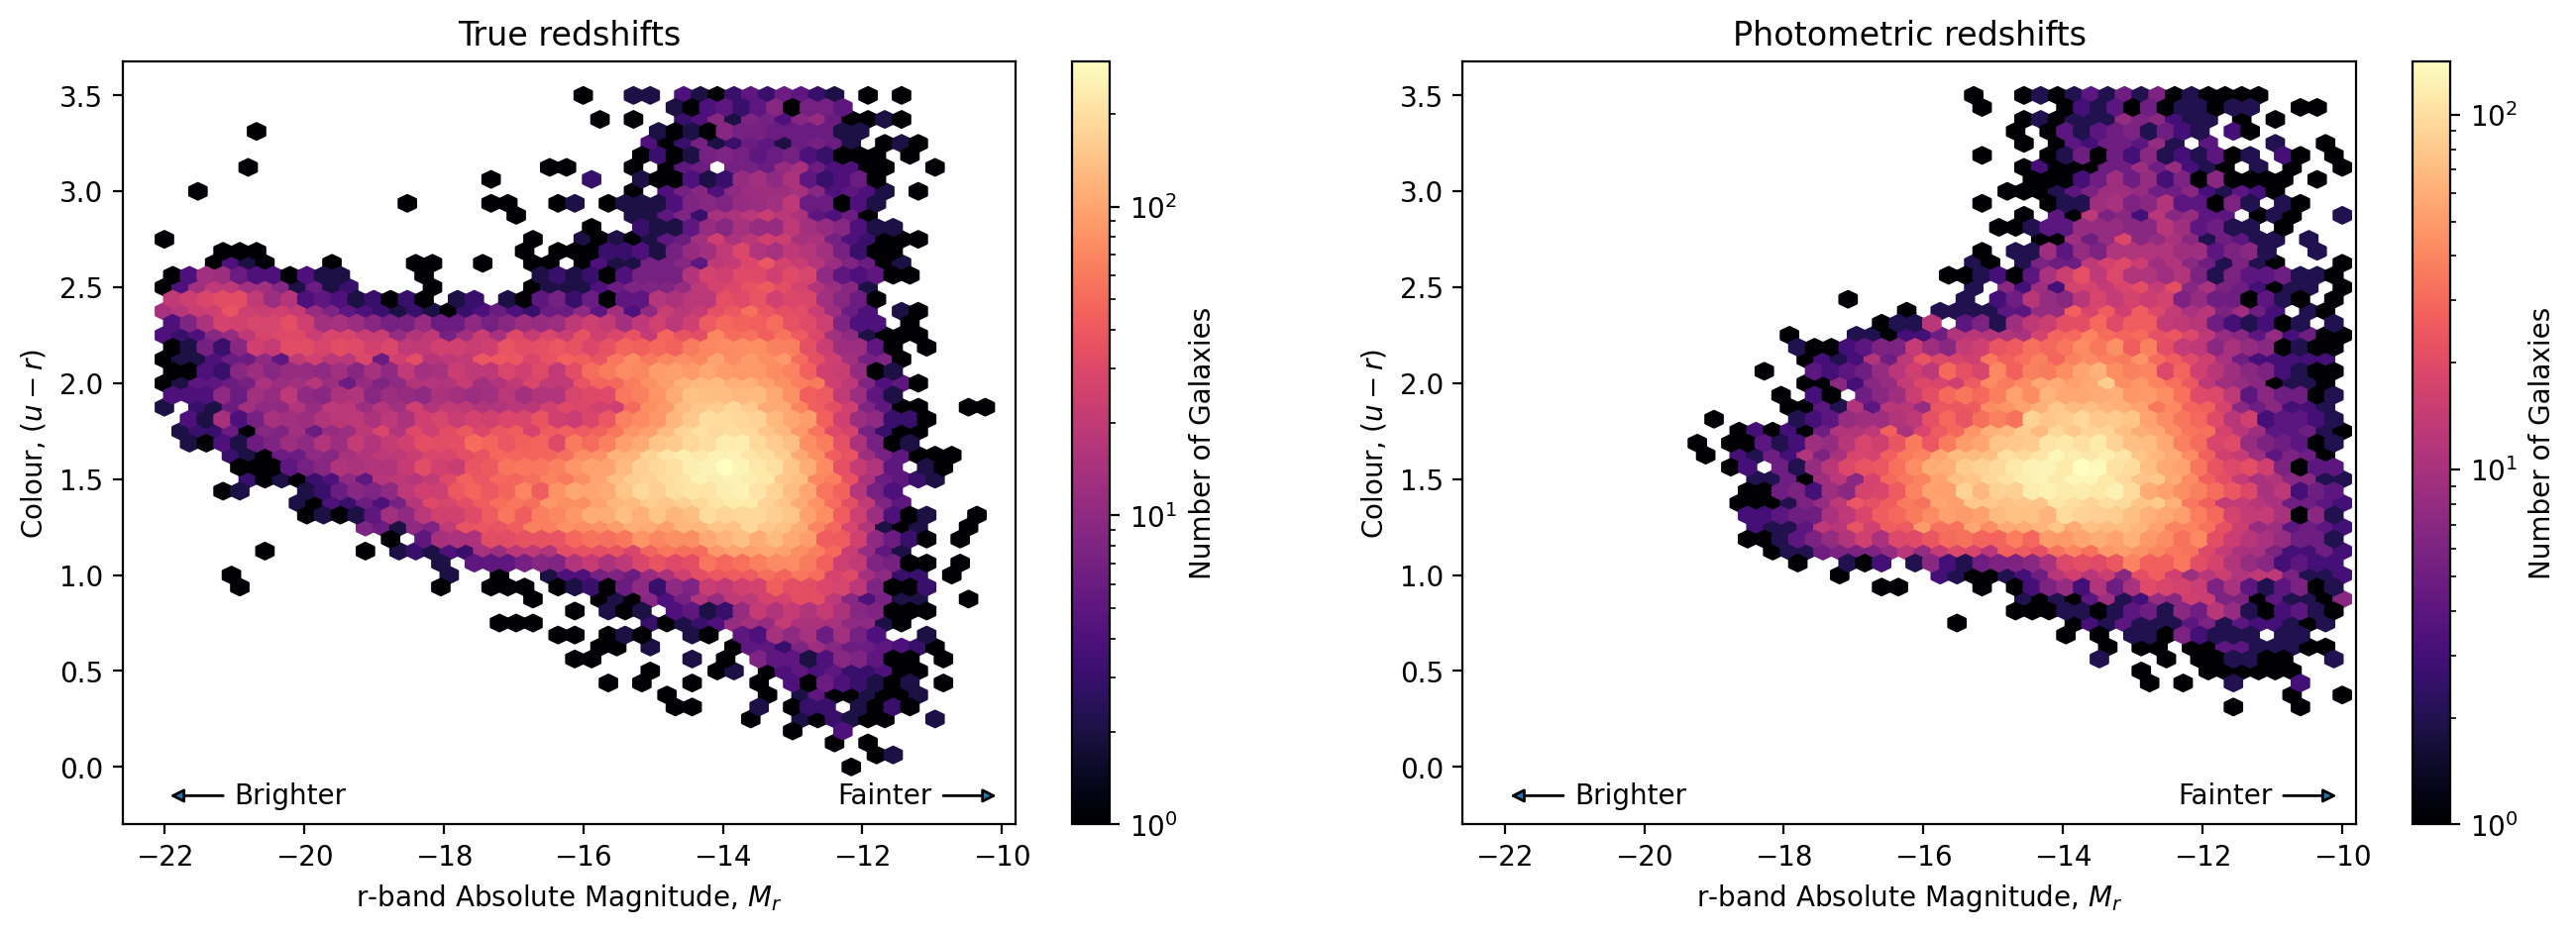

In [215]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))


hexbin = axes[0].hexbin(r_mag, u_mag - r_mag, extent=(-22, -10, 0, 3.5),
                        gridsize=50, bins="log", cmap="magma")
fig.colorbar(hexbin, label="Number of Galaxies", ax=axes[0])

hexbin = axes[1].hexbin(photoz_r_mag, photoz_u_mag - photoz_r_mag, extent=(-22, -10, 0, 3.5),
                        gridsize=50, bins="log", cmap="magma")
fig.colorbar(hexbin, label="Number of Galaxies", ax=axes[1])

for ax in axes:
    ax.annotate("Brighter", xy=(-22, -0.15), xytext=(-21, -0.15), arrowprops=dict(arrowstyle="-|>"), va="center")
    ax.annotate("Fainter", xy=(-10, -0.15), xytext=(-11, -0.15), arrowprops=dict(arrowstyle="-|>"), va="center", ha="right")

    ax.set_xlim(right=-9.8)
    ax.set_ylim(bottom=-0.3)

    ax.set_xlabel("r-band Absolute Magnitude, $M_r$")
    ax.set_ylabel("Colour, $(u - r)$")
    
axes[0].set_title("True redshifts")
axes[1].set_title("Photometric redshifts")
    
plt.show()

From this we can see that the magnitudes are shifter fainter significantly when using photo-Zs (at least with this simple estimate).